# ДЗ3 Анна Головина группа БКЛ213

Вы видите этот файл, потому что тетрадка получилась крайне тяжелая, пришлось резать на 2 части, а все из-за того, что код слишком тяжелый, а для DS Browse просто не хватает памяти компьютера.

In [21]:
from matplotlib import pyplot as plt
import pandas as pd
import sqlite3

In [4]:
con = sqlite3.connect("imdb_small_indexed.db")
cur = con.cursor()

# Второе задание

(не очень поняла, надо ли делать задание не из маркированного списка: *Посмотрите, какое среднее распредление долей мужчин и женщин в фильмах разных лет по жанрам*, потому что нет ничего ни про визуализацию, ни про что, так что не делала)

*посчитайте долю женщин среди участников фильмов жанра определенного года*

Для начала посмотрим базу данных и что она в целом может сказать про гендерный состав.

In [216]:
sample_query = """
SELECT *
FROM role_categories
"""

sample = [item for item in cur.execute(sample_query).fetchall()]
print(*sample, sep="\n")

(1, 'actor')
(2, 'actress')
(3, 'archive_footage')
(4, 'archive_sound')
(5, 'cinematographer')
(6, 'composer')
(7, 'director')
(8, 'editor')
(9, 'producer')
(10, 'production_designer')
(11, 'self')
(12, 'writer')


Хотя бы как-то отличить женщин от мужчин можно только при оценке каста, так что так и будем делать.

Честно говоря, я пыталась сделать это через COUNT изначально, но ничего не вышло, если пытаться максимально запросом выудить информацию. Потом пыталась оставить COUNT только в числителе дроби, опять не вышло ничего, так что лучшим решением кажется комбинация команд SUM CASE WHEN, потому что там не надо после джоинов еще прописывать WHERE, который будет сбивать все подсчеты и обнулять дробь. В начале вычислений домножаю на 100, потому что хочу увидеть проценты, а не просто долю от единички.

Изначальный запрос выглядел примерно так:
fem_fract_query = """
SELECT genre_name, premiered,
100 * COUNT(role_type) / COUNT(role_type in ("actor", "actress")) AS fem
FROM crew AS c
    JOIN titles AS t ON t.title_id = c.title_id
    JOIN film_genres AS fg ON t.title_id = fg.title_id
    JOIN genre_types AS gt ON fg.genre_id = gt.id
    JOIN role_categories AS r ON c.category = r.id
WHERE role_type = "actress"
GROUP BY premiered, genre_name
"""

Но я понимаю, что COUNT не считает так, как я хочу, знаменатель, так что я пыталась придумать какие-то альтернативы, но кроме SUM CASE WHEN особо ни до чего не догадалась.

In [33]:
fem_fract_query = """
SELECT premiered, genre_name,
100 * SUM(CASE WHEN role_type = "actress" THEN 1 ELSE 0 END) / SUM(CASE WHEN role_type in ("actor", "actress") THEN 1 ELSE 0 END) AS fem
FROM crew AS c
    JOIN titles AS t ON t.title_id = c.title_id
    JOIN film_genres AS fg ON t.title_id = fg.title_id
    JOIN genre_types AS gt ON fg.genre_id = gt.id
    JOIN role_categories AS r ON c.category = r.id
GROUP BY premiered, genre_name
"""

In [34]:
cur.execute(fem_fract_query).fetchall()

[(None, 'Action', 28),
 (None, 'Adult', 27),
 (None, 'Adventure', 31),
 (None, 'Animation', 34),
 (None, 'Biography', 33),
 (None, 'Comedy', 39),
 (None, 'Crime', 32),
 (None, 'Documentary', 27),
 (None, 'Drama', 40),
 (None, 'Family', 41),
 (None, 'Fantasy', 39),
 (None, 'Game-Show', 34),
 (None, 'History', 30),
 (None, 'Horror', 41),
 (None, 'Music', 35),
 (None, 'Musical', 39),
 (None, 'Mystery', 40),
 (None, 'News', 20),
 (None, 'Reality-TV', 36),
 (None, 'Romance', 44),
 (None, 'Sci-Fi', 37),
 (None, 'Short', 49),
 (None, 'Sport', 21),
 (None, 'Talk-Show', 41),
 (None, 'Thriller', 38),
 (None, 'War', 25),
 (None, 'Western', 26),
 (1894, 'Romance', 33),
 (1897, 'Documentary', None),
 (1897, 'News', None),
 (1897, 'Sport', None),
 (1898, 'Documentary', None),
 (1898, 'Sci-Fi', None),
 (1899, 'Documentary', None),
 (1899, 'News', None),
 (1899, 'Sport', None),
 (1900, 'Biography', 16),
 (1900, 'Comedy', None),
 (1900, 'Documentary', None),
 (1900, 'Drama', 16),
 (1900, 'News', None),

Создаю сводную таблицу по уже полученным из запроса данным. Чтобы датафрейм не пестрил NaN, заполняю нулями. То, что годы в виде числа с плавающей запятой, меня не смущает, так что менять типа на int не буду.

In [35]:
df = pd.read_sql_query(fem_fract_query, con=con)
cast_fem = pd.pivot_table(
    df, index=["premiered"], columns=["genre_name"], values="fem", fill_value=0
)
cast_fem

genre_name,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
premiered,,,,,,,,,,,,,,,,,,,,,
1894.0,0,0,0,0,0,0,0,0,0,0,...,0,0,33,0,0,0,0,0,0,0
1900.0,0,0,0,0,16,0,0,0,16,0,...,0,0,0,0,0,0,0,0,0,0
1902.0,0,0,0,0,0,0,0,0,100,0,...,0,0,0,0,0,0,0,0,0,0
1903.0,0,0,0,0,50,0,0,0,50,0,...,0,0,0,0,0,0,0,0,0,0
1906.0,0,0,0,0,50,66,50,0,50,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024.0,52,0,57,0,0,50,0,0,43,0,...,0,0,57,0,0,0,0,50,0,50
2025.0,0,0,50,0,50,0,0,0,66,0,...,0,0,0,0,0,0,0,0,0,0
2026.0,75,0,75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*изучите, какие есть закономерности и опишите их*

Для этого необходимо увидеть всю таблицу. что возможно только если сохранить таблицу в файл. Я сохраню в формате tsv, так как он более читаемый в случае моей сводной таблицы, чем csv.

In [36]:
cast_fem.to_csv("table_fem_fract.tsv", sep="\t")

Если оценить глазами файл, лично меня привлекли данные, полученные по драмам, фильмам ужасов и научной фантастике (но о них красноречиво скажет график).

Если говторить про общие закономерности, то заметно, что женщины в конце 19 века и начале 20 века не очень активно участвовали в развитии киноиндустрии, также резкий спад виден после 2022 года (скорее всего, это связано с тем, что фильмы еще не релизили, а потому состав еще уточняется, и указаны далеко не все актрисы).

Если оценивать глазами без привлечения статистических модулей и библиотек, кажется, будто женщины больше всего снимались в период на стыке 20 и 21 века, а самыми излюбленными жанрами для большого количества женских ролей являются документальные фильмы, романтические фильмы и мюзиклы.

*проиллюстрируйте с помощью графика 2-3 наиболее примечательных жанра*

С помощью обычного матплотлибовского графика вставляю ломаные (как точки подаются числа по колонкам, соответствующим выбранным жанрам).
Для того, чтобы оценить ситуацию в индустрии в целом и сравнить с двумя выбранными жанрами, посмотрим ломаную, соответствующую драмам и ломаную по научной фантастике (просто из датафрейма выудила значения пропорции, посчитанной по запросу). Сделала их синим и красным цветом.

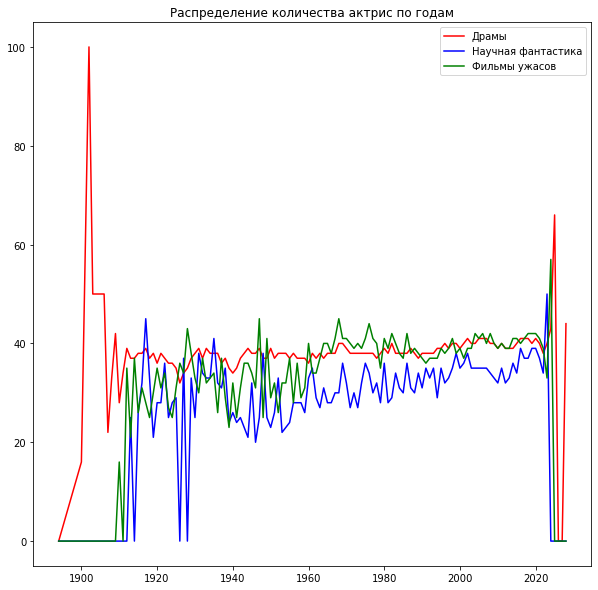

In [30]:
plt.figure(figsize=(10,10))
plt.title("Распределение количества актрис по годам")
dramas = plt.plot(cast_fem["Drama"], color="red", label="Драмы")
sci = plt.plot(cast_fem["Sci-Fi"], color="blue", label="Научная фантастика")
hor = plt.plot(cast_fem["Horror"], color="green", label="Фильмы ужасов")

plt.legend(loc="best")

plt.show()

*можно ли сделать какие-то выводы об изменениях в индустрии?*

Кажется, будто доля женщин в драмах со временем начала падать, причем с достаточно резкими перепаадми (в начале 20 века и в начале 21 контрасты ярче всего).

В научной фантастике, напротив, доля женщин будто увеличивается, при этом заметно снижение контрастов по годам с резким провалом после 2020 года (возможно, дело в том, что база не пополняется новыми данными о фильмах, которые будут выпущены после 2022, и в них просто не может содержаться информация о том, сколько женщин участвует в съемках).
В целом, видно, что в киноиндустрии работает не очень много женщин (почти все пики графиков находятся ниже 40, и уж точно ниже 50).

В фильмах ужасов количество актрис резко возрастает примерно в 1910-е, а затем держится почти стабильно выше количества актрис в научной фантастике.

# Третье задание

Допустим, что база данных, с которой я работала в этой домашке - единственное, что есть в распоряжении для создания сайта.

*1. С какими объектами мы работаем? Какие таблицы нужно добавить в базу? Какие параметры нужно хранить?*

Объекты (если речь про новые при создании сайта объекты базы данных): новые таблицы, запросы, возможно модули на чем-то типа VBA (я допускаю, что для реализации некоторых задач SQL будет мало, если воплотить амбиции из п.5 в жизнь).

Работаем с IP-адресами (иные данные о пользователях, кроме тех, что они сами укажут на сайте, по сути и невозможно достать). Но лучше IP, потому что я бы хотела дать возможность оценки фильма еще и неавторизованным пользователям (зачем? ну пусть будет). Параметры, которые желательно хранить в такой базе данных - оценка пользователя по фильму, количество посещений, количество оценок (эти два параметра нужны для того, чтобы создать как бы иерархию активных пользователей, данные которых я буду считать релевантными для кластеризации см.п.5), возможно еще стоит регистрировать и каким-то образом хранить способ поиска того или иного фильма (по режиссеру; по актерам, исполняющим главные роли; по году; по жанру и т.п., но это опять же к параметрам кластеризации см.п.5).

*2. Как эти таблицы связаны между собой и с таблицами, уже имеющимися в базе?*

(стрелочками показала на схеме см. п. 3)

*3. Нарисуйте схему и прокомментируйте (схему можно положить картинкой в репозиторий или вставить в тетрадку).*

Добавила в репозиторий фотку схемы.

*4. Какие данные нужно будет часто доставать или соединять? Какие индексы в базе хорошо было бы создать, чтобы пользователю было комфортно и быстро получать статистику или какую-то иную информацию. (Представьте, например, свои действия при работе с КиноПоиском или IMDB).*

Собственно характеристики фильма с разных точек зрения. Например, имя режиссера возможно придется соединять с жанром или названием фильма, жанры с годами, имена актеров с именами режиссеров.

Про индексы. Я так поняла, речь про всякие кластерные и некластерные индексы, наверное. Вообще хранить информацию кучей, кажется, не очень хорошо, а упорядочивание помогает обеспечить только кластерный тип, так что эти индексы и создадим.

*5. Каких данных (с сайта или просто придумать свои) не хватает в базе?*

Собственно, обновляемой таблицы с оценками пользователей (ну тут, наверное, краулер будет лишним, можно просто написать скрипт, который будет в определенное время проверять суточную активность на сайте, регистрировать уникальные IP-адреса и их активность). Мне кажется, нет смысла на сайте показывать данные о пользователях, люди склонны голосовать скорее в анонимизированных опросах и т.п., так что IP-адреса пусть хранятся в этой таблице. Но об этой таблице я уже написала ранее.

Я решила придумать свои данные, а не опираться на сайты, потому что я как пользователь кино-сервиса хотела бы, наверное, иметь возможность делать какие-то подборки исходя из рекоммендаций. Так что можно еще сделать, наверное, некоторую сводную таблицу, которая будет кластеризовать высокие оценки от определенных IP-адресов. Если на это все накрутить нейронку, она будет хорошие рекомендации выдавать новым пользователям (да и старым тоже) на основе кластерного анализа (это к слову к VBA).

Еще я бы в порядке бреда стала определять по IP регион, в котором находится пользователь (мало ли, вдруг Челябинск, например, массово любит хорроры, и им надо рекомендовать триллеры и ужастики чаще).

На этом фантазия кончилась.